In [2]:
import torch
from torch import optim
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
from IPython import display
%matplotlib inline

In [3]:
use_cuda  = torch.cuda.is_available()

In [4]:
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# Create training and test dataloaders

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)

0it [00:00, ?it/s]

9920512it [00:01, 7244013.61it/s]                             


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 437845.90it/s]
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 5727672.19it/s]                           
8192it [00:00, 179120.23it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.conv3 = nn.Conv2d(32, 800, 5)
        self.conv4 = nn.Conv2d(800, 800, 1)
        self.conv5 = nn.Conv2d(800, 10, 1)
        self.pool = nn.MaxPool2d((2,2))
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        
        return x

In [6]:
model = Model()
if use_cuda:
    model = model.cuda()

In [7]:
def train_model(model, train_loader, test_loader, n_epochs, use_cuda):
    # specify loss function (categorical cross-entropy)
    criterion = nn.CrossEntropyLoss()
    # specify optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    min_test_accuracy = 0
    for epoch in range(1, n_epochs+1):

        # keep track of training and validation loss
        train_loss = 0.0
        train_accuracy = 0
        test_accuracy = 0
        ###################
        # train the model #
        ###################
        model.train()
        for images, labels in train_loader:
            # move tensors to GPU if CUDA is available
            if use_cuda:
                images = images.cuda()
                labels = labels.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            logits = model(images).squeeze()
            _, outs_k = logits.topk(1, dim=1)
            equals = (outs_k == labels.view(*outs_k.shape))
            train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # calculate the batch loss
            loss = criterion(logits, labels)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()


        train_loss = train_loss/len(train_loader)
        train_accuracy /= len(train_loader)
            # print training/validation statistics 
        model.eval()
        for images, labels in test_loader:
            if use_cuda:
                images = images.cuda()
                labels = labels.cuda()
            logits = model(images).squeeze()
            _, outs_k = logits.topk(1, dim=1)
            equals = (outs_k == labels.view(*outs_k.shape))
            test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        test_accuracy /= len(test_loader)
        print("""Epoch: {} \tTraining Loss: {:.6f} 
        \tTrain accuracy: {:.6f} \Test accuracy: {:.6f}""".format(
            epoch, train_loss,  train_accuracy, test_accuracy))
    
        # save model if validation loss has decreased
        if test_accuracy >= min_test_accuracy:    
            torch.save(model.state_dict(), 'model.pt')
            min_test_accuracy = test_accuracy

In [8]:
train_model(model, train_loader, test_loader, 5, use_cuda)

Epoch: 1 	Training Loss: 0.125322 
        	Train accuracy: 0.961767 \Test accuracy: 0.985100
Epoch: 2 	Training Loss: 0.050315 
        	Train accuracy: 0.985800 \Test accuracy: 0.987700
Epoch: 3 	Training Loss: 0.035781 
        	Train accuracy: 0.990333 \Test accuracy: 0.990700
Epoch: 4 	Training Loss: 0.027040 
        	Train accuracy: 0.992533 \Test accuracy: 0.988700
Epoch: 5 	Training Loss: 0.023238 
        	Train accuracy: 0.993333 \Test accuracy: 0.989600


In [9]:
model.eval()

Model(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 800, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(800, 800, kernel_size=(1, 1), stride=(1, 1))
  (conv5): Conv2d(800, 10, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
)

In [10]:
CONFIDENCE_LEVEL = 0.99

In [11]:
def pyramid(image, scale=1.5, minSize=(28, 28)):
    # yield the original image
    yield image

    # keep looping over the pyramid
    while True:
        # compute the new dimensions of the image and resize it
        w = int(image.shape[2] / scale)
        h = int(image.shape[1] / scale)
        image = F.interpolate(test_image.unsqueeze(dim=0), (h,w), mode='bilinear' ,align_corners=False)[0]
        if use_cuda:
            image = image.cuda()            
        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[1] < minSize[1] or image.shape[2] < minSize[0]:
            break

        # yield the next image in the pyramid
        yield image

In [12]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[1], stepSize):
        for x in range(0, image.shape[2], stepSize):
            # yield the current window

            yield (x, y, image[:, y:y + windowSize[1], x:x + windowSize[0]])

In [13]:
random_idx = np.random.randint(batch_size)
train_iterator = iter(train_loader)
images, labels = train_iterator.next()

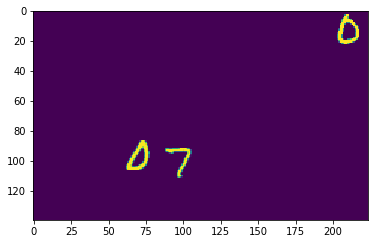

In [14]:
first_tensor = images[random_idx]
second_tensor = images[(random_idx+1)%batch_size]
third_tensor = images[(random_idx+2)%batch_size]

black_tensor = torch.zeros_like(first_tensor)

tmp_0 = torch.cat((black_tensor, black_tensor, black_tensor, black_tensor,
                   black_tensor, black_tensor, black_tensor, third_tensor), 2)
tmp_1 = torch.cat((black_tensor, black_tensor, black_tensor, black_tensor,
                   black_tensor, black_tensor, black_tensor, black_tensor), 2)
tmp_2 = torch.cat((black_tensor, black_tensor, black_tensor, black_tensor,
                   black_tensor, black_tensor, black_tensor, black_tensor), 2)

tmp_3 = torch.cat((black_tensor, black_tensor,first_tensor, second_tensor,
                   black_tensor, black_tensor, black_tensor, black_tensor), 2)
tmp_4 = torch.cat((black_tensor, black_tensor, black_tensor, black_tensor,
                   black_tensor, black_tensor, black_tensor, black_tensor), 2)

test_image = torch.cat((tmp_0, tmp_1, tmp_2, tmp_3, tmp_4), 1)

if use_cuda:
    test_image_numpy = test_image.cpu().numpy().squeeze()
else : 
    test_image_numpy = test_image.numpy().squeeze()
    
plt.imshow(test_image_numpy)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


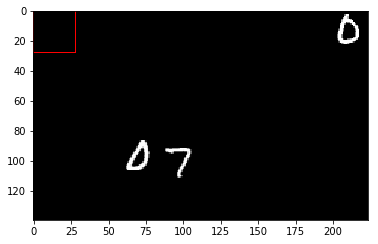

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


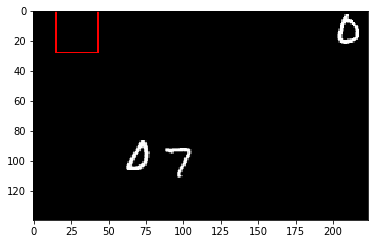

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


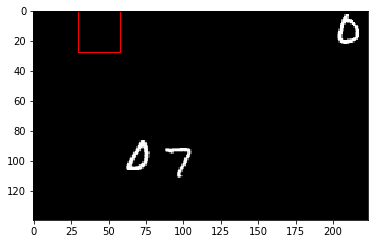

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


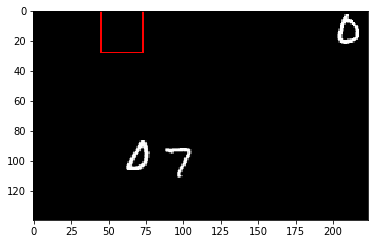

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


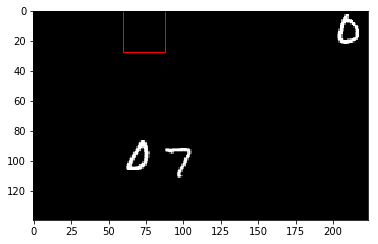

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


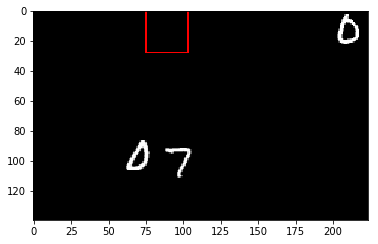

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


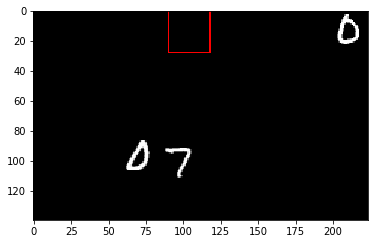

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


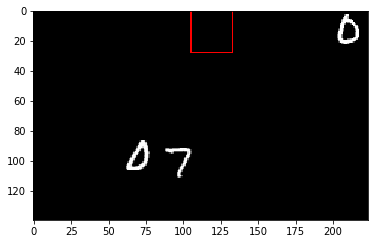

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


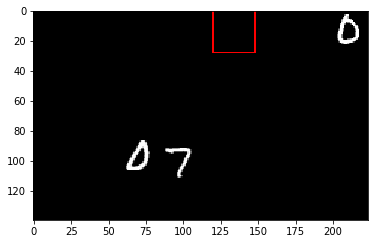

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


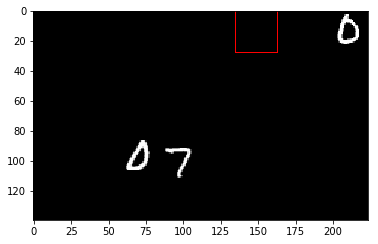

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


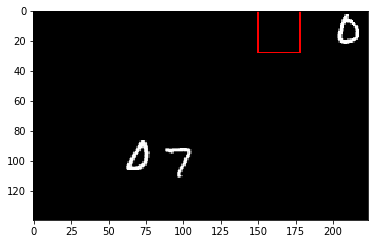

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


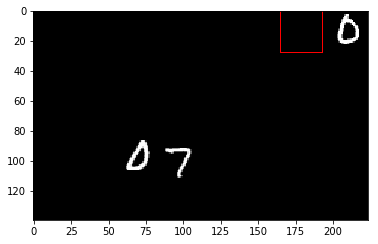

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


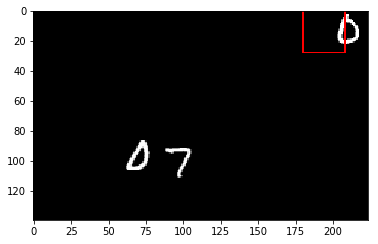

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


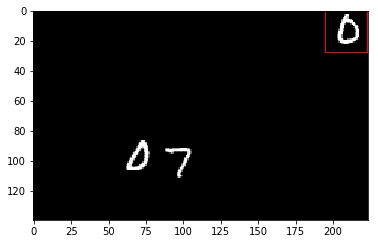

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


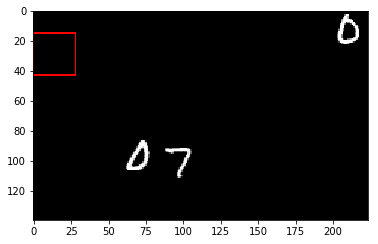

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


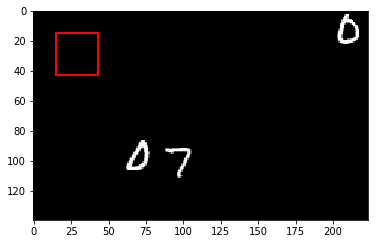

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


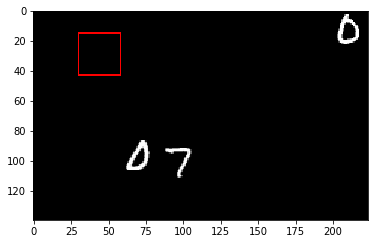

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


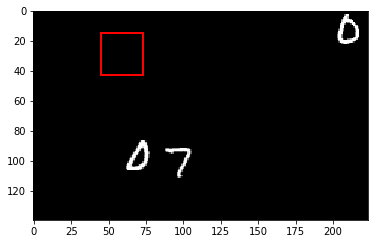

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


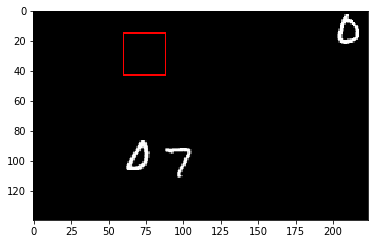

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


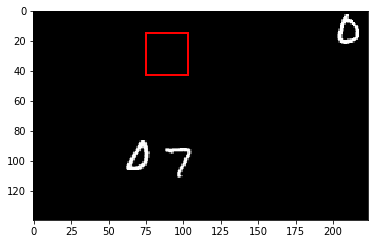

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


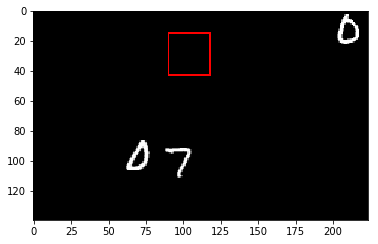

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


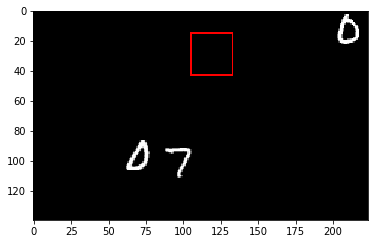

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


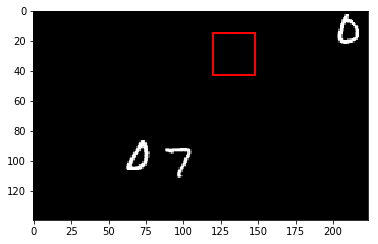

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


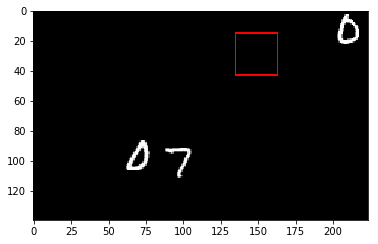

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


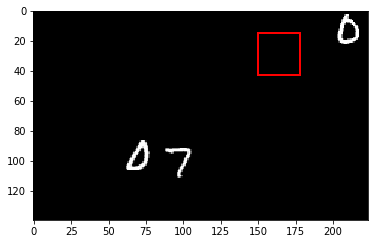

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


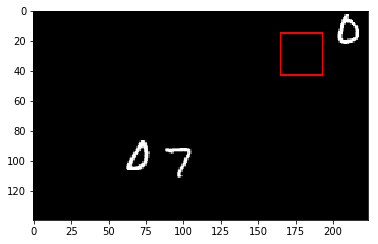

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


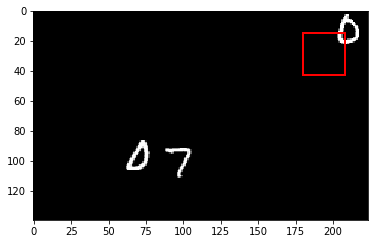

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


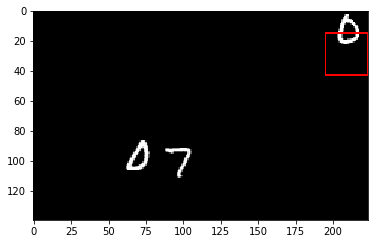

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


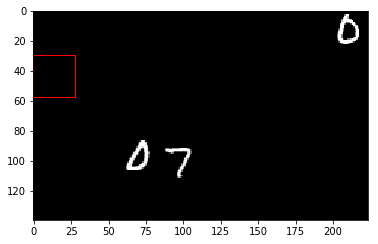

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


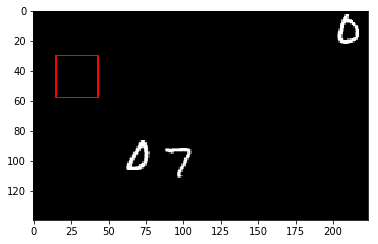

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


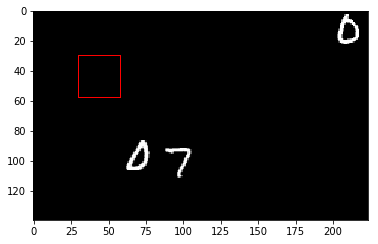

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


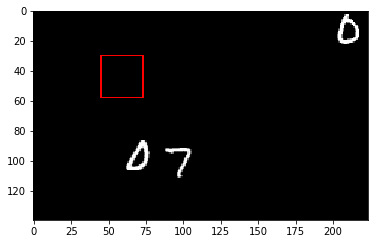

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


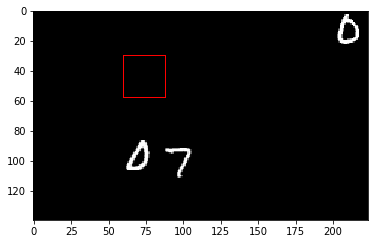

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


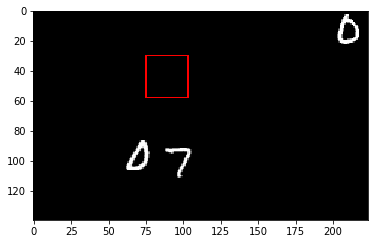

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


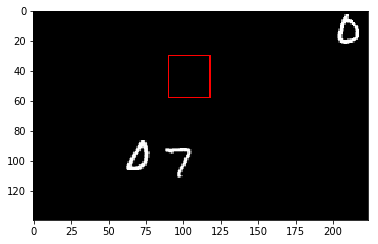

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


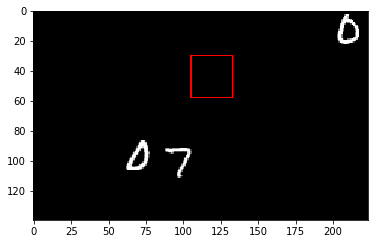

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


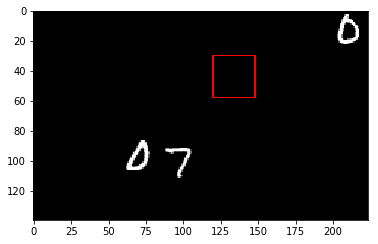

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


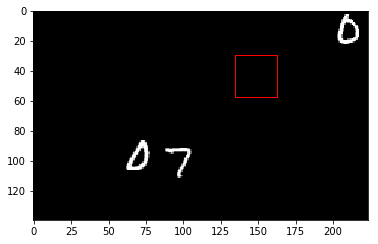

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


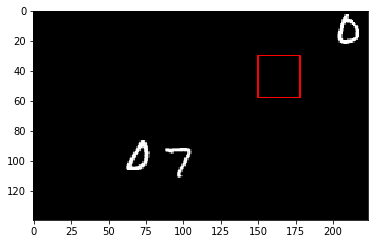

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


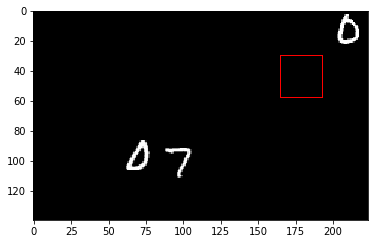

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


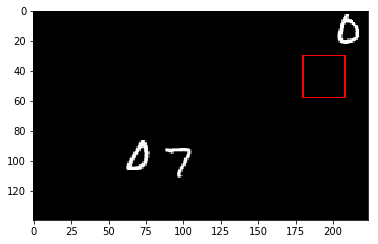

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


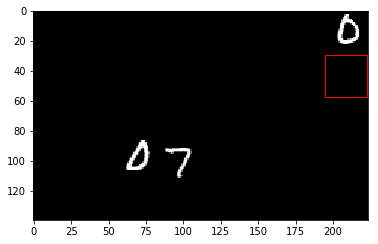

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


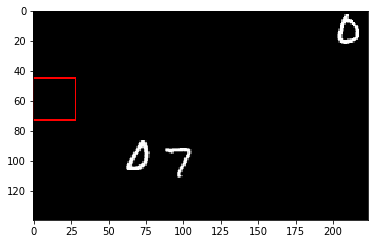

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


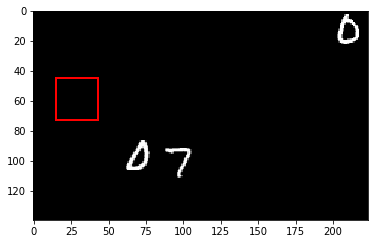

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


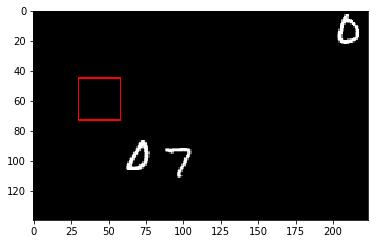

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


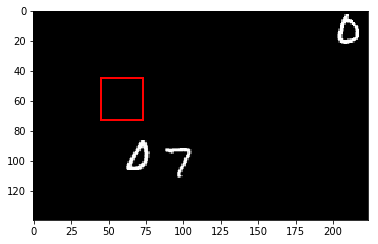

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


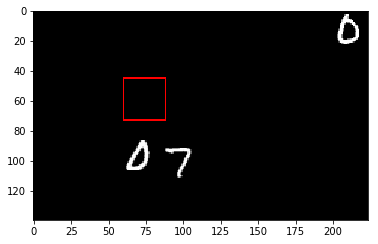

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


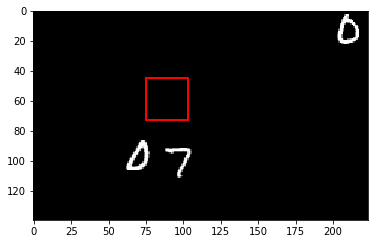

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


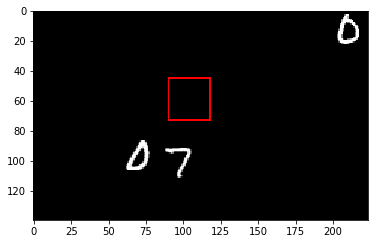

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


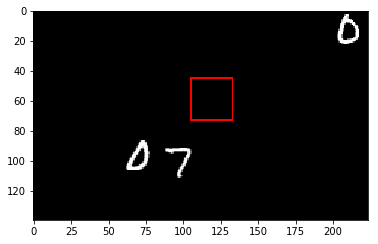

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


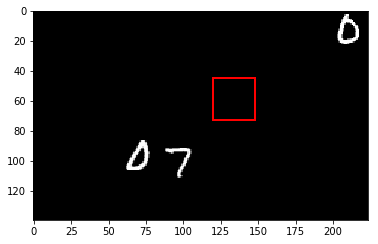

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


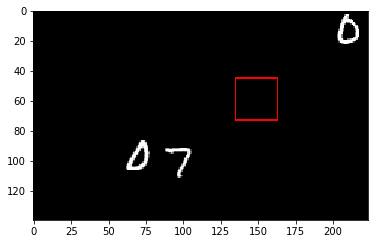

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


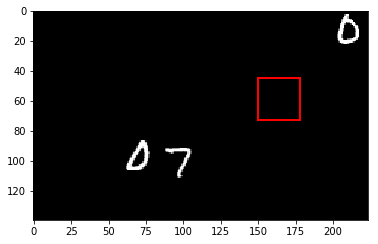

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


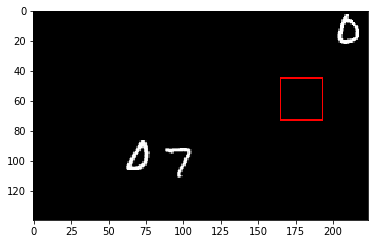

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


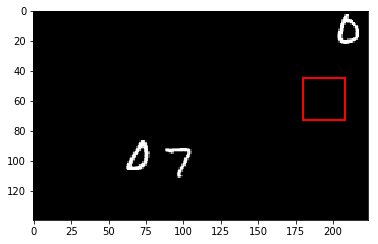

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


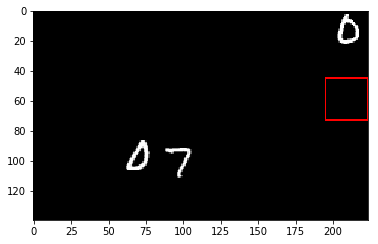

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


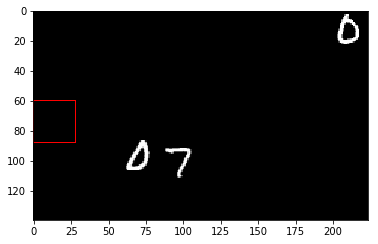

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


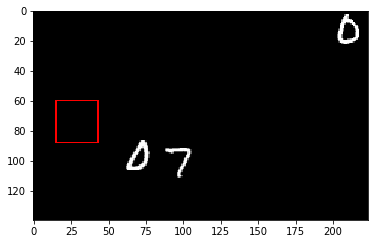

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


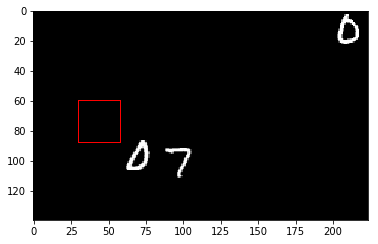

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


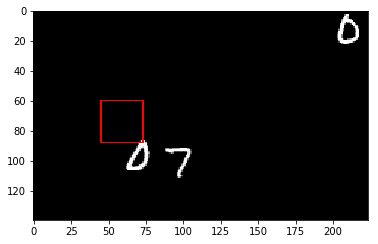

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


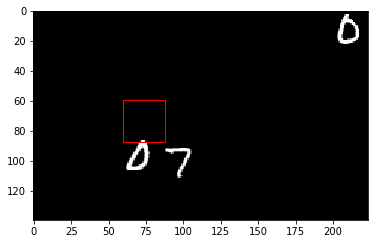

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


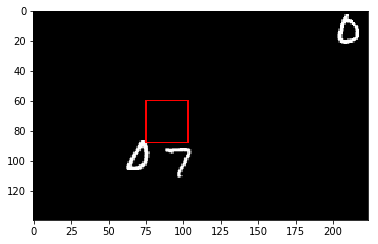

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


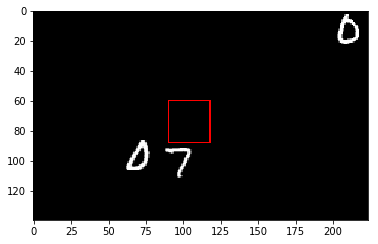

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


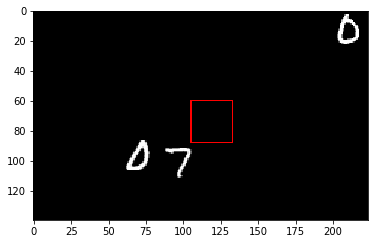

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


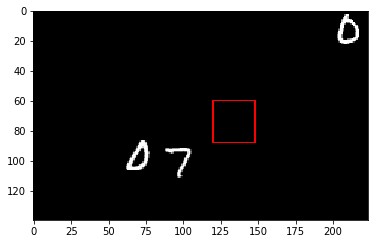

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


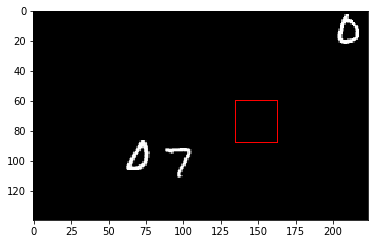

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


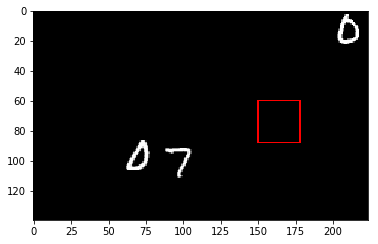

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


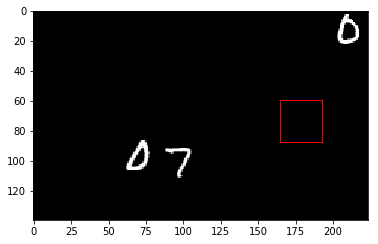

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


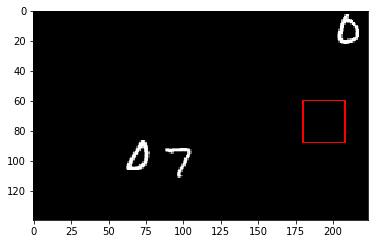

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


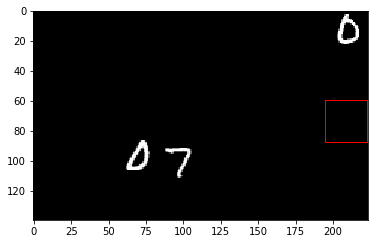

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


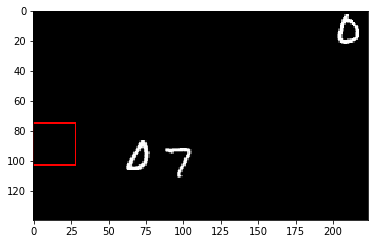

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


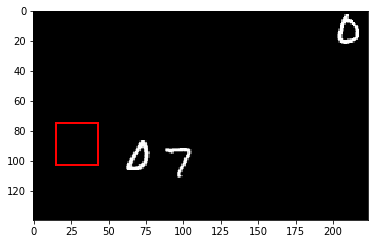

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


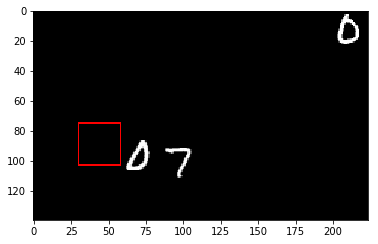

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


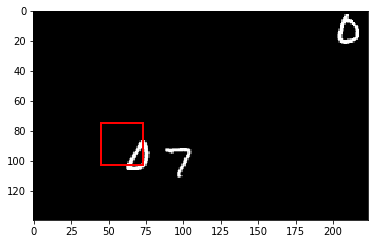

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


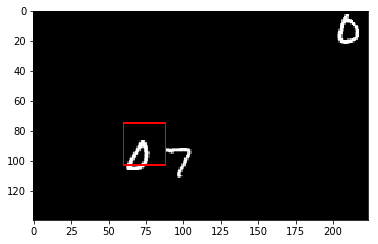

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


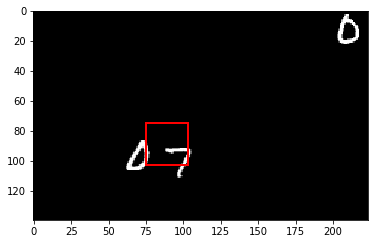

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


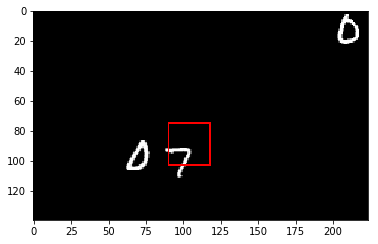

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


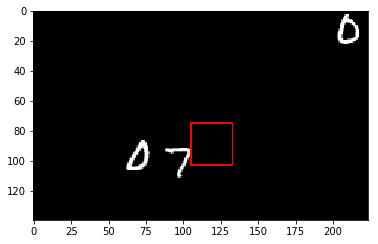

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


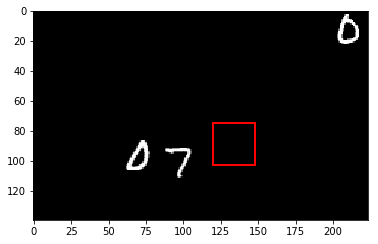

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


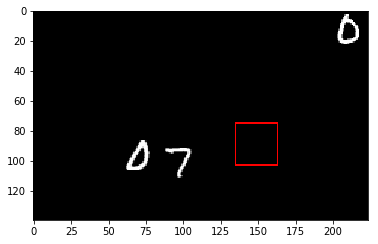

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


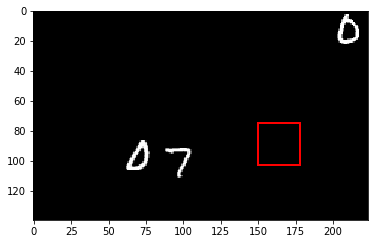

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


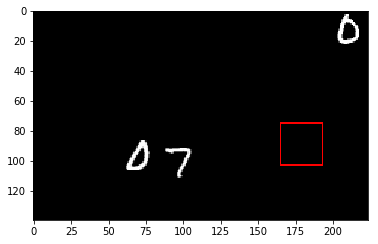

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


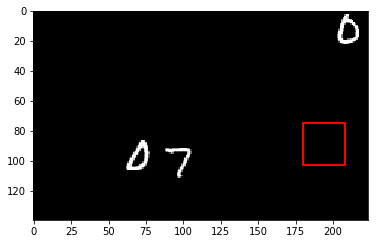

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


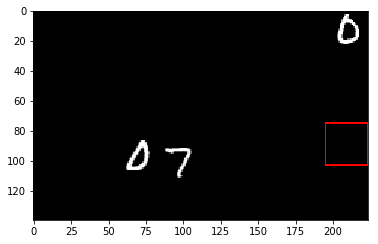

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


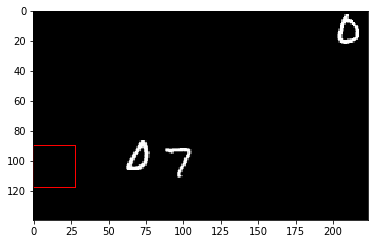

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


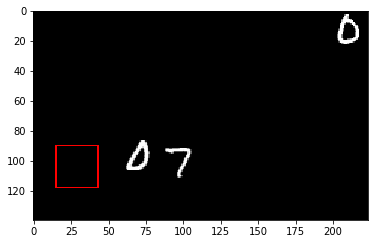

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


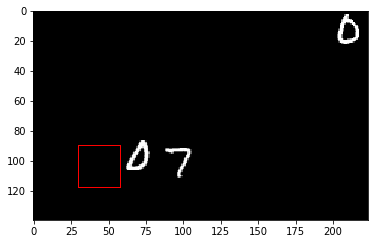

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


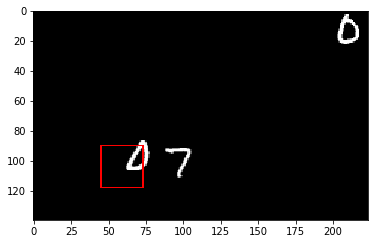

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


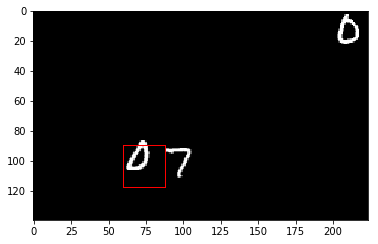

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


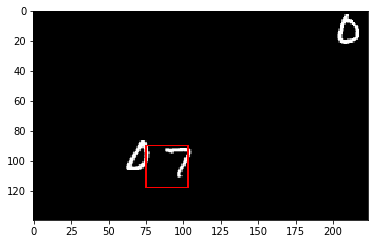

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


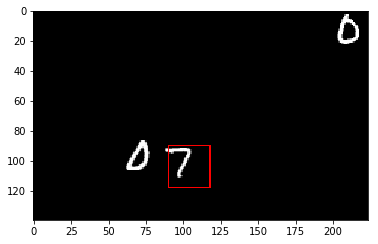

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


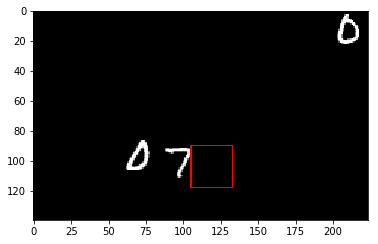

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


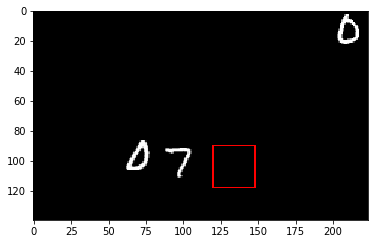

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


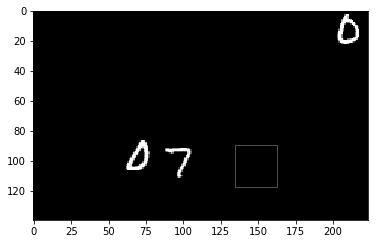

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


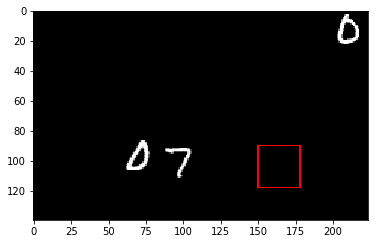

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


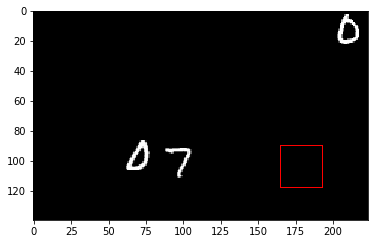

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


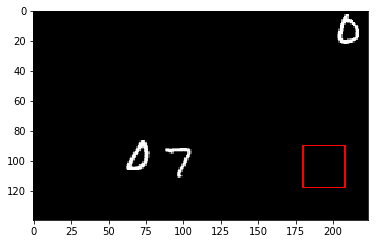

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


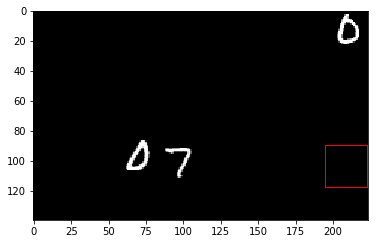

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


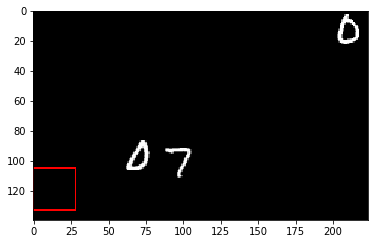

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


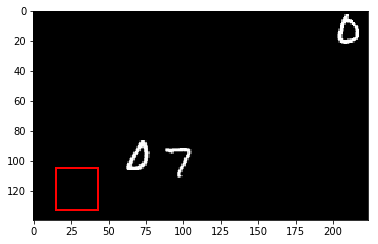

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


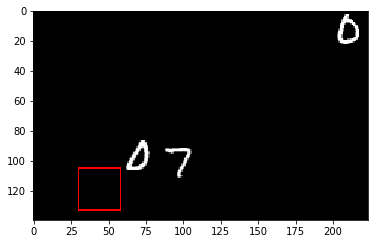

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


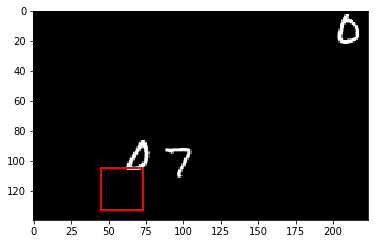

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


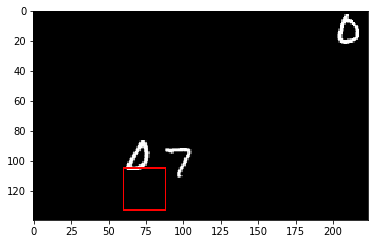

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


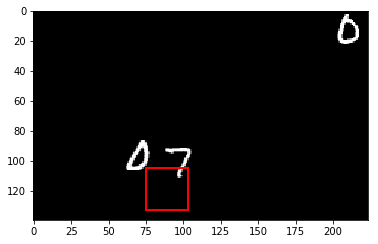

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


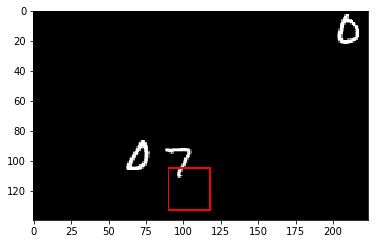

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


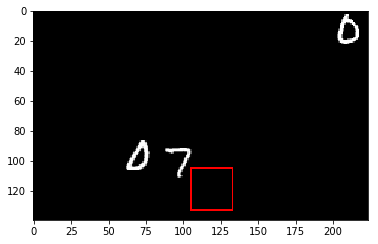

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


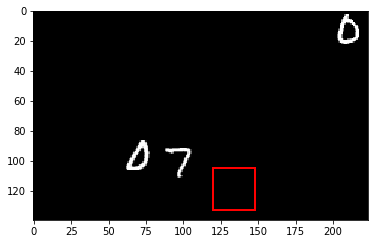

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


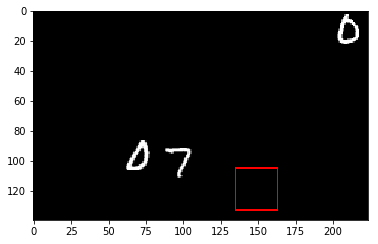

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


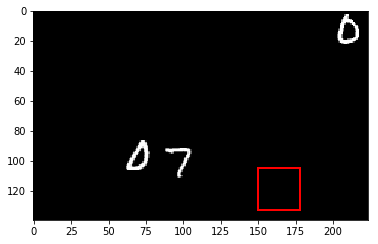

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


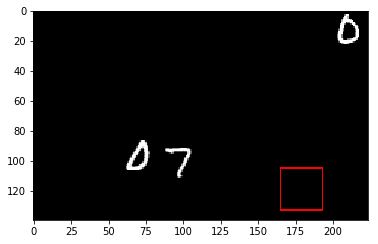

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


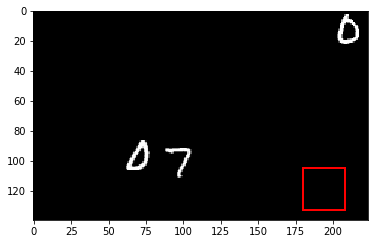

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


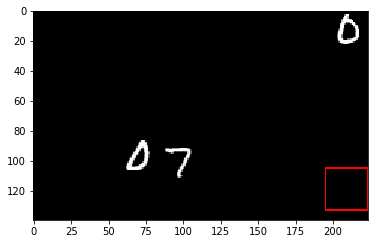

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


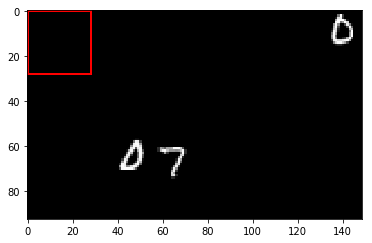

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


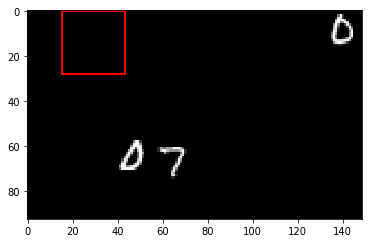

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


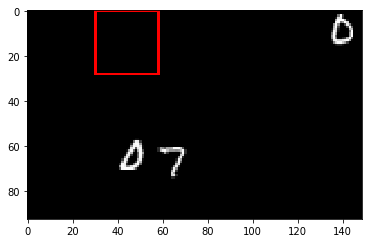

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


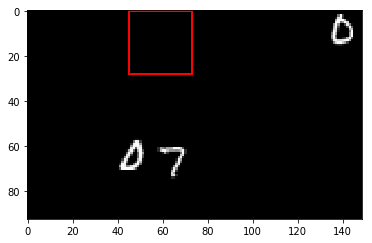

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


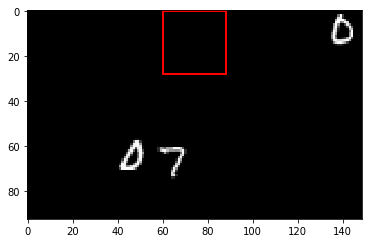

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


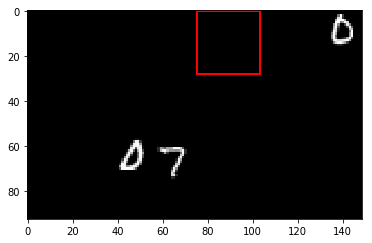

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


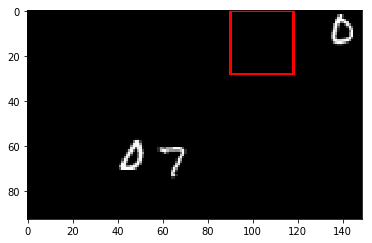

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


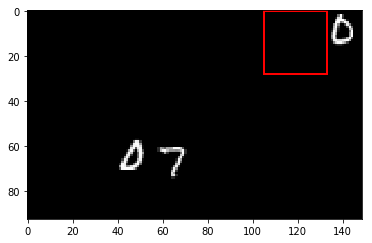

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


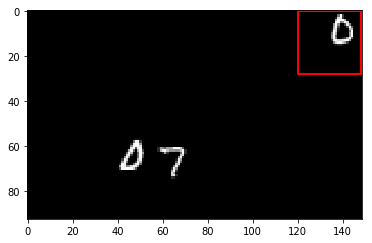

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


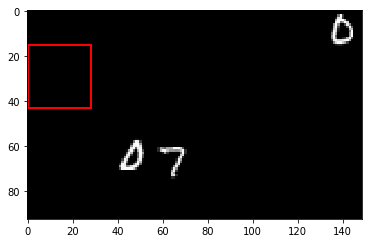

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


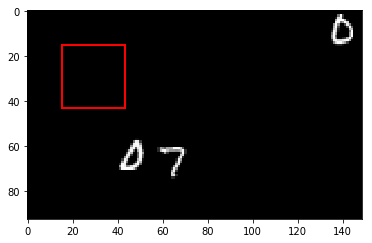

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


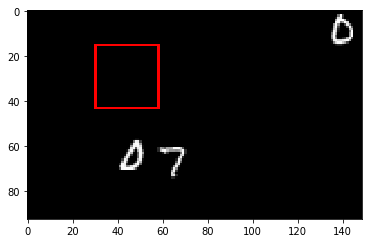

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


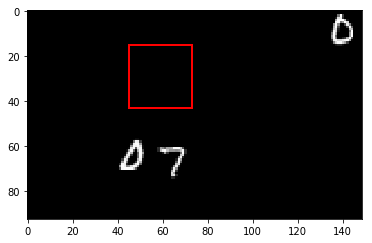

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


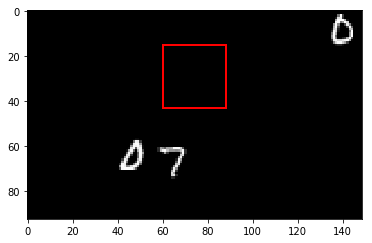

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


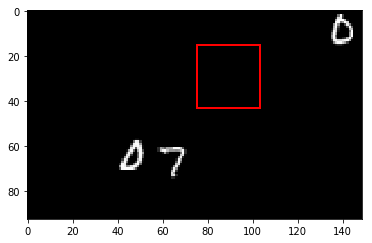

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


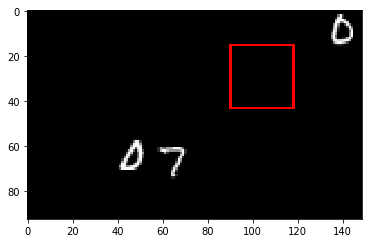

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


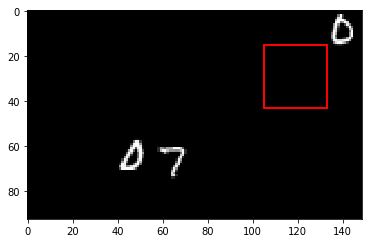

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


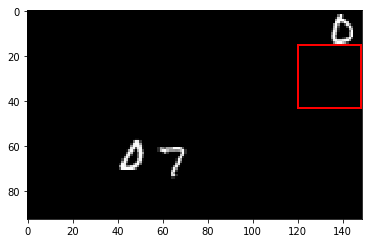

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


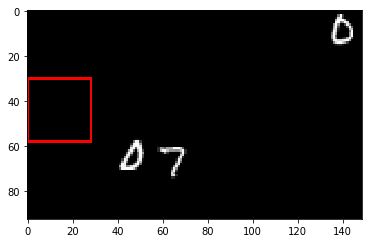

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


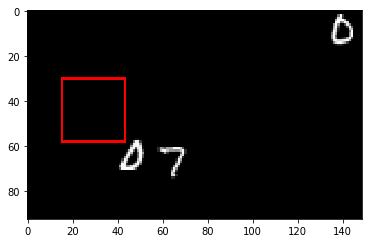

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


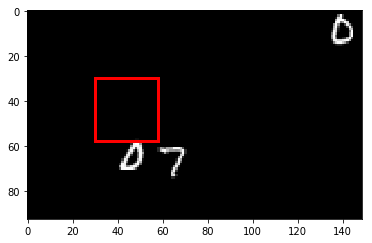

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


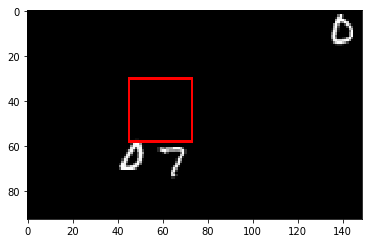

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


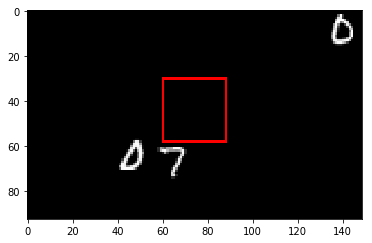

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


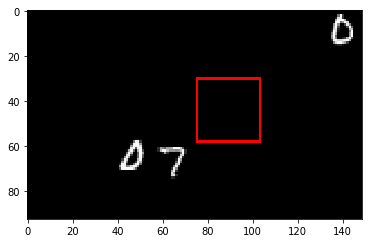

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


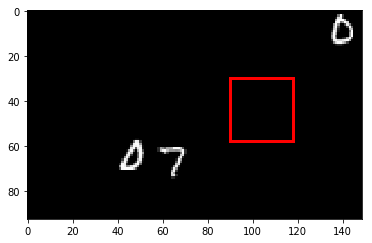

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


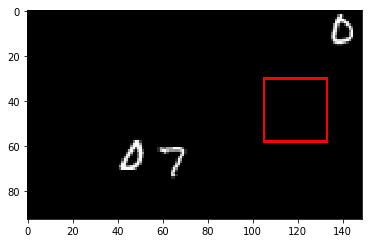

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


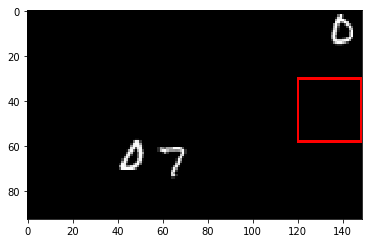

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


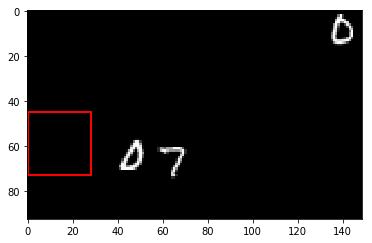

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


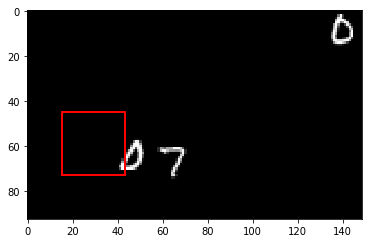

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


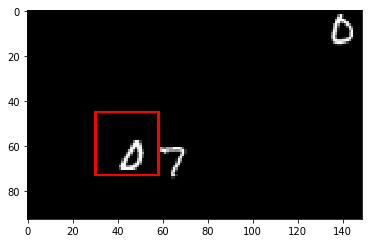

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


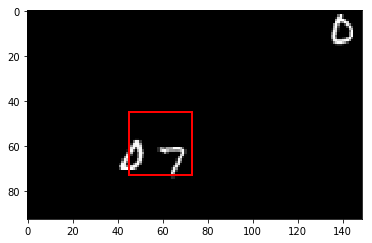

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


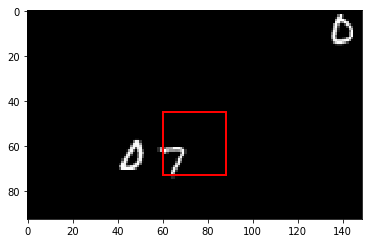

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


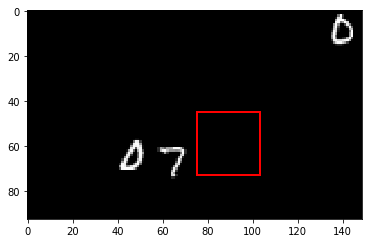

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


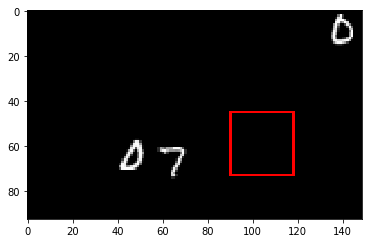

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


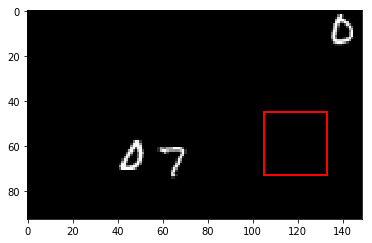

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


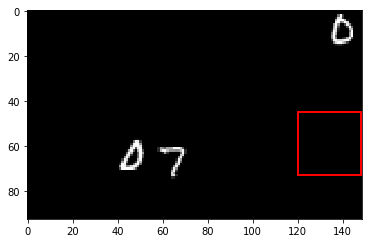

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


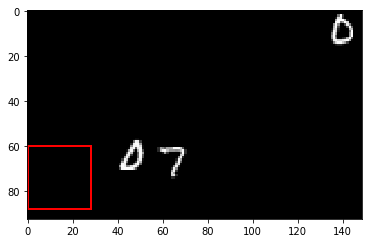

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


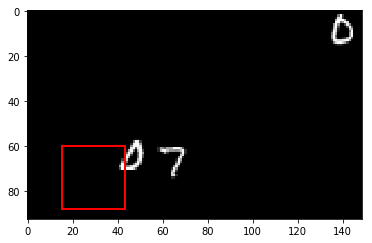

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


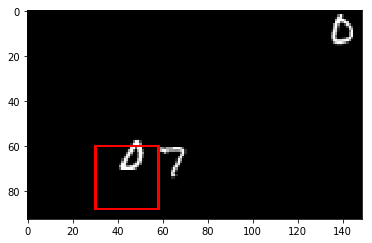

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


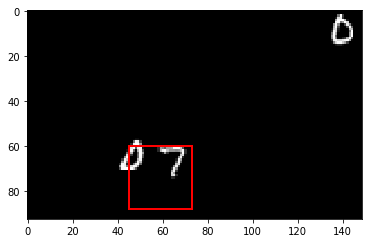

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


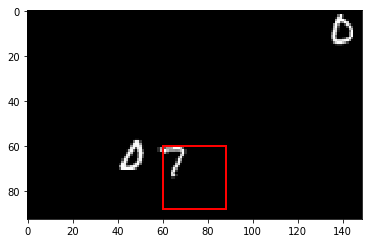

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


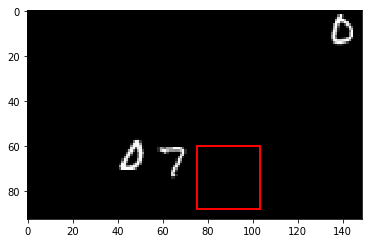

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


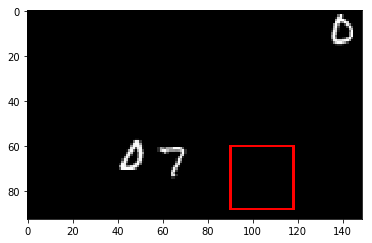

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


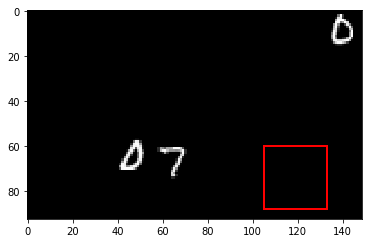

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


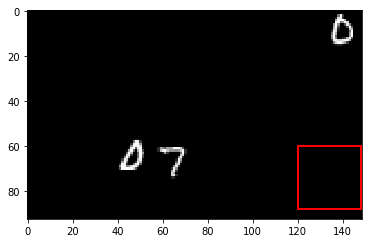

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


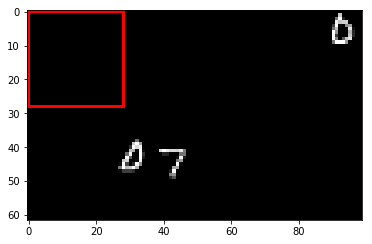

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


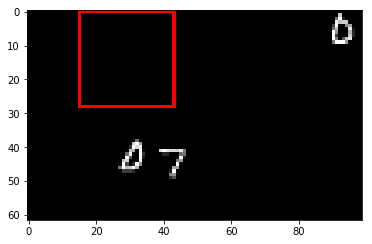

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


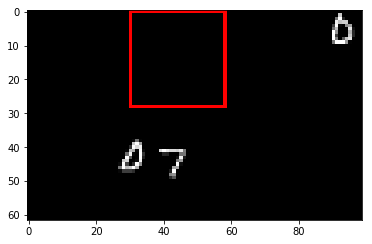

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


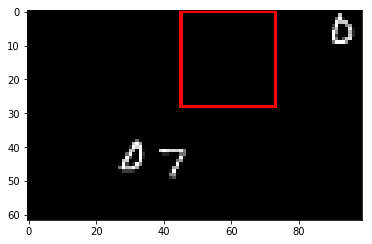

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


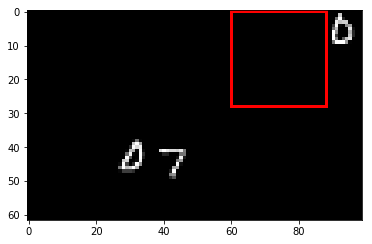

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


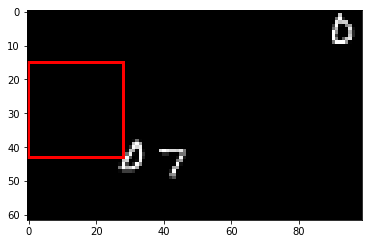

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


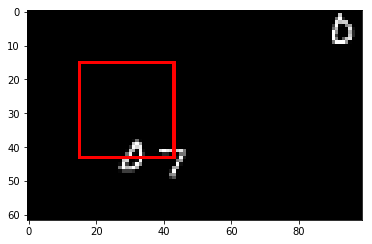

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


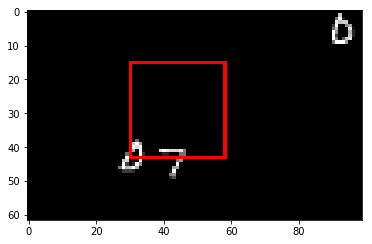

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


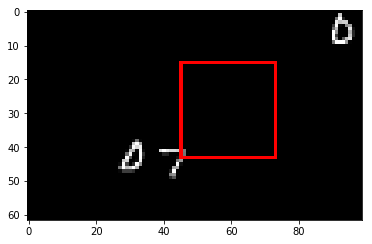

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


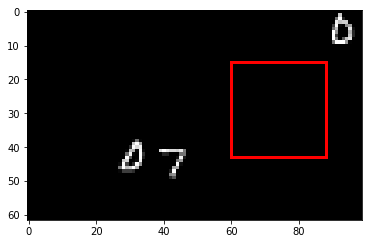

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


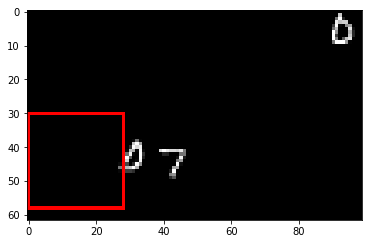

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


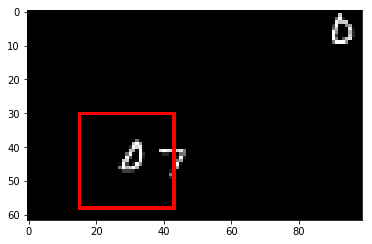

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


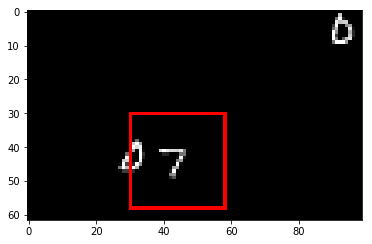

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


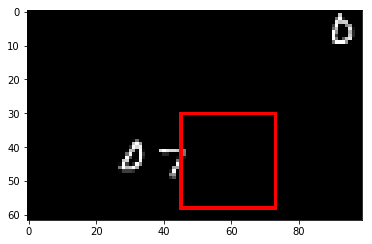

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


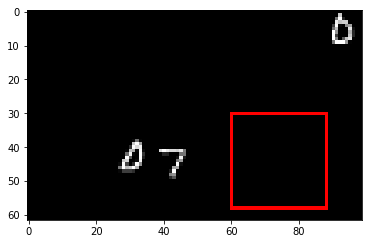

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


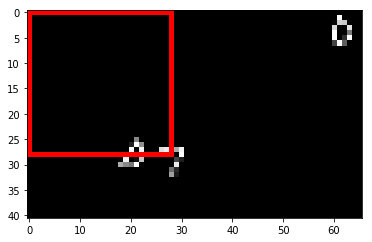

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


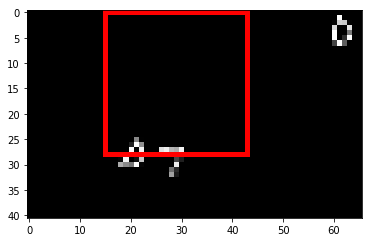

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


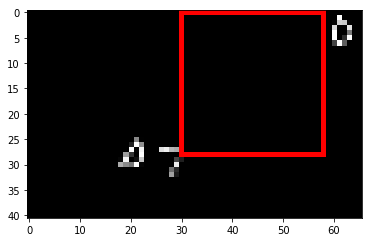

<Figure size 432x288 with 0 Axes>

In [15]:
plt.ion()
for resized in pyramid(test_image, scale=1.5):
    for (x, y, window) in sliding_window(resized, stepSize=15, windowSize=(28, 28)):
        if window.shape[1] != 28 or window.shape[2] != 28:
            continue
            
        if use_cuda:
            clone = resized.cpu().detach().numpy().copy().squeeze()
        else:
            clone = resized.numpy().copy().squeeze()
        clone = cv2.cvtColor(clone, cv2.COLOR_GRAY2BGR)
        clone = cv2.rectangle(clone, (x, y), (x + 28, y + 28), (255, 0 , 0), 1)
        plt.imshow(clone)
        plt.pause(0.0001)
        plt.clf()

In [16]:
def confident_boxes(img, step_size=4, window_size=(28,28),scale=1.5):
    confidence_boxes = []
    for i,resized in enumerate(pyramid(img, scale)):
        for (x, y, window) in sliding_window(resized, step_size, window_size):
            if window.shape[1] != window_size[1] or window.shape[2] != window_size[0]:
                continue
            prediction = F.softmax(model(window.unsqueeze(dim=0)))
            values, indices = prediction.squeeze().max(0)
            if values > CONFIDENCE_LEVEL:                
                y, x = scale**i * y, scale**i * x
                confidence_boxes.append([y,x,window_size[1], window_size[0]])
        
    
    confidence_boxes = np.array(confidence_boxes).astype(int)
    confidence_boxes= confidence_boxes[confidence_boxes[:,0].argsort()]
    return confidence_boxes


In [17]:
confidence_boxes = confident_boxes(test_image.cuda(), 4, (28,28))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


In [18]:
def draw_predictions(image, confident_locations):
    for y, x, box_size_y, box_size_x in confident_locations:
        image = cv2.rectangle(image,(x,y),(x+box_size_x,y+box_size_y),(255,0,0),1)
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


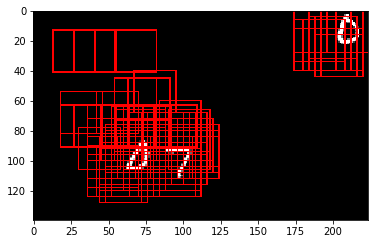

In [19]:
detection_conf_loc_image = cv2.cvtColor(test_image_numpy.copy(), cv2.COLOR_GRAY2BGR)
detection_conf_loc_image = draw_predictions(detection_conf_loc_image, confidence_boxes)
plt.imshow(detection_conf_loc_image)

In [20]:
def expansion(bounding_boxes, slide_x = 1, slide_y=1):
    nb_boxes = len(bounding_boxes)   
    idx = 0
    while idx < nb_boxes-1:
        y1, x1, box_size_y1, box_size_x1 = bounding_boxes[idx]
        y2, x2, box_size_y2, box_size_x2 = bounding_boxes[idx+1]      
        if (((x1 + box_size_x1 + slide_x >= x2) or (x2 + box_size_x2 + slide_x >= x1))
            and (y1 + box_size_y1 + slide_y >= y2)):
            x = min(x1, x2)
            y = min(y1, y2)
            box_size_y = max(y2+box_size_y2, y1+box_size_y1) - min(y1,y2)
            box_size_x = max(x2+box_size_x2, x1+box_size_x1) - min(x1,x2)
            bounding_boxes[idx]= np.array([y, x, box_size_y, box_size_x])
            bounding_boxes = np.delete(bounding_boxes, idx+1, axis = 0 )
            nb_boxes = len(bounding_boxes)   
        else:
            idx+=1

    return bounding_boxes

In [21]:
test = expansion(confidence_boxes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


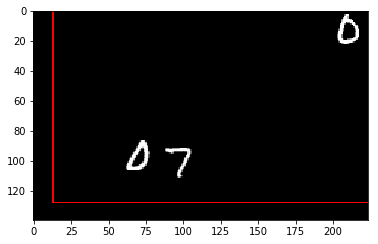

In [22]:
detection_conf_loc_image = cv2.cvtColor(test_image_numpy.copy(), cv2.COLOR_GRAY2BGR)
detection_conf_loc_image = draw_predictions(detection_conf_loc_image, test)
plt.imshow(detection_conf_loc_image);